# Ant Colony Decision Making

A myriad of scientific advancements have been made by developing methods and tools modeled off of natural phenomena. Ant colonoy optimization algorithms are one example of where nature has inspired scientific tools. In nature, ants have shown the ability to find short paths between their nests and a food source, despite having limited sight and memory capabilities. This ability is instead derived from ants' use of pheromones to mark paths. Ants deposit pheromone as the move along a path, and then tend to follow paths with more pheromone while exploring an area. Shorter paths will transport more ants over extended time periods, and so will accumulate greater quantities of pheromone in the long run.

## A Simple Decision

While in reality ants explore complicated natural environments, this optimization behavior can be seen even in a very simple scenario, where ants traverse back and forth between a single food source and their nest when their path is obstructed by an obstacle. Given that the two paths around the obstacle differ in length, we can show that ants will tend towards the shorter path.

In [1]:
from matplotlib import pyplot as plt
from matplotlib.patches import FancyBboxPatch
import numpy as np

Say we begin with a geometry where an anthill and a food source are separated by an obstacle. There are two paths (one of length 3, and one of length 5) around the obstacle. 

In [2]:
# List the vertices where ants will be on our map
vertices = [(4,1),(4,2),(4,3),(3,3),(2,3),(2,4),(3,4),(5,3),(5,4),(4,4),(4,5),(4,6)]
# Giving the vertices actual names.
A,B,C,D,E,G,H,I,J,K,L,M = vertices   
names = ['$A$','$B$','$C$','$D$','$E$','$G$','$H$','$I$','$J$','$K$','$L$','$M$']

# Create a blank map and label it
labeledmap = np.empty((8,8),dtype='<U10')
for vert,name in zip(vertices,names):
    labeledmap[vert]=name

This geometry is set up and drawn by the following function, and labeled blocks mark each unit length path segment.

In [3]:
def simple_decision_map(verts,point_vals,color1='k',color2='k',linestyle1='--',linestyle2='--',alpha1=1,alpha2=1):
    """
    Plot the map of the situation for ants finding food.
    """
    mapfig = plt.figure(figsize=(10,10))
    plt.axis('equal')
    ax = mapfig.add_subplot(111)
    path1 = np.array([verts[0],verts[1],verts[2],verts[3],verts[4],verts[5],verts[6],verts[9],verts[10],verts[11]])
    path2 = np.array([verts[0],verts[1],verts[2],verts[7],verts[8],verts[9],verts[10],verts[11]])
    plt.plot(path1[:,0],path1[:,1],c=color1,ls=linestyle1,alpha=alpha1)
    plt.plot(path2[:,0],path2[:,1],c=color2,ls=linestyle2,alpha=alpha2)
    plt.xlim(0,7)
    plt.ylim(0,7)
    plt.text(4,0.5,'ANTHILL',verticalalignment='top',horizontalalignment='center',fontsize=16)
    plt.text(4,6.5,'FOOD',verticalalignment='bottom',horizontalalignment='center',fontsize=16)
    plt.text(1.7,3.5,'PATH 1',verticalalignment='center',horizontalalignment='right',fontsize=16)
    plt.text(5.3,3.5,'PATH 2',verticalalignment='center',horizontalalignment='left',fontsize=16)
    for vertex in verts:
        x,y = vertex
        val = point_vals[vertex]
        plt.text(x,y,val,verticalalignment='center',horizontalalignment='center',
                 bbox=dict(facecolor='w',edgecolor='k'),fontsize=14)
    p_bbox = FancyBboxPatch((2.25, 3.35),
                            2.5, 0.3,
                            boxstyle="round,pad=0.1", label='Obstacle',
                            ec="k", fc="#d3d3d3", zorder=10.,
                            )
    ax.add_patch(p_bbox)

    plt.show()

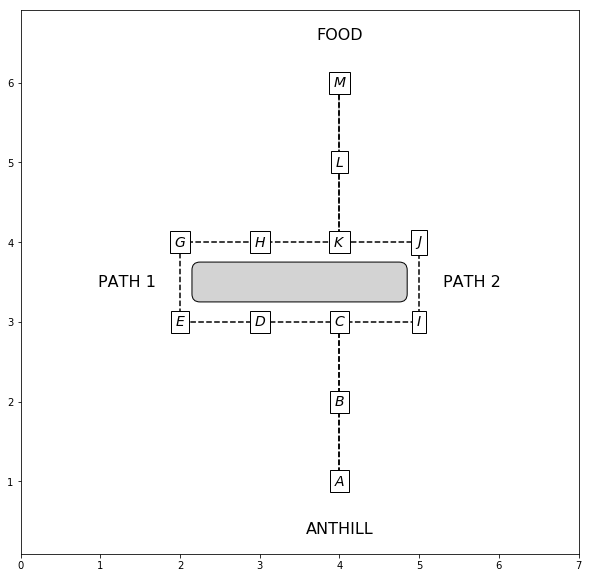

In [4]:
plt.clf()
simple_decision_map(vertices,labeledmap)

We start with 30 ants at point $A$, 30 ants at point $L$, and zero ants everywhere else.

In [5]:
def initial_ant_counts(ants_at_food,ants_at_hill):
    N = np.zeros((8,8),dtype=int)
    N[A],N[M] = ants_at_food,ants_at_hill
    return N

In [6]:
N = initial_ant_counts(30,30)

While we're at it, we will also make a dictionary noting which points are turns, which are endpoints, and which are intersections.

In [7]:
keypoints = {'path 1 turns': [E,G],     
             'path 2 turns': [I,J],
             'endpoints': [A,M],
             'intersections': [C,K]
             }

Let's now look at our diagram of the situation as it initially unfolds.

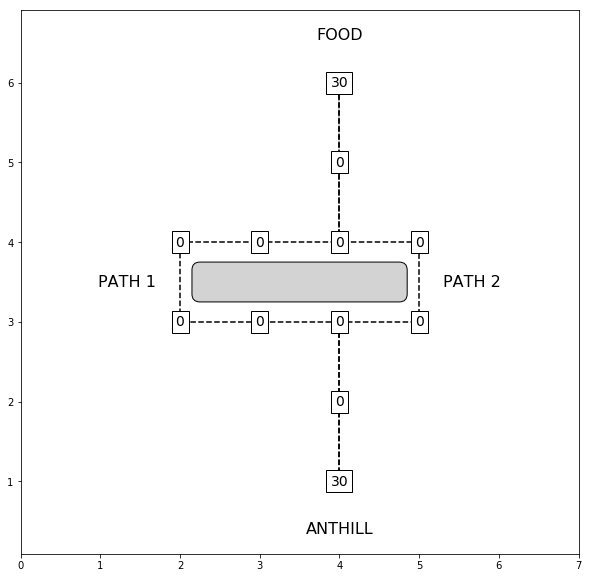

In [8]:
simple_decision_map(vertices,N)

Now let's consider our ants. Each ant at $A$ is going to move up towards the food, and each ant at $D$ is going to move down toward the anthill. Once the ant reaches an intersection, it will choose which way to proceed (path 1 or 2). This decision will happen randomly when the ant has no information to base its decision on, but otherwise will tend to favor the direction with more pheromone laid by the ants before it. There are many probability distributions which we could use to describe this decision, but we will use a simple one.

$$ P(i) = \begin{cases} \frac{f_i}{\sum_i f_i},     & \sum_i f_i \neq 0 \\
                                  \frac{1}{2},      & \sum_i f_i = 0 \\
                    \end{cases}, \, i \in \{1,2\}$$
                    
where $f_i$ is the pheromone left on path $i$. Noting that $p(2) = 1-p(1)$, we can write this function in code as:

In [9]:
def prob_path1(f):
    """
    Function to compute the probability of the ant going path 1 or 2.
    
    f : list (length 2)
        Pheromone totals on the path 1 and path 2, in that order.
    """
    if sum(f) != 0:
        P1 = f[0]/sum(f)
    else:
        P1 = 0.5
    return P1

At the start, there is no pheromone anywhere in the space.

In [10]:
def initial_pheromone():
    global F
    F = np.zeros((7,7,2))   # In this array, F[x,y,0] corresponds to the pheromone value between (x,y) and (x+1,y)
                            #            and F[x,y,1] corresponds to the pheromone value between (x,y) and (x,y+1)

In [11]:
initial_pheromone()

Next, we will capture any given ant using a class. This ant class will specify where the ant is, which direction the ant is going, and the probability function governing the ant's decisions. It will also contain methods for moving, depositing pheromone, and if necessary, executing decisions.

In [12]:
class Ant:
    """
    A class describing an ant and modeling it's behavior.
    
    position : tuple
        The ant's position, given as the ordered pair (x,y)
    destination : str
        The destination of the ant, either to the food or the anthill
    decision_function : func
        The probability function governing the ant's decisions.
    keypoints : dict
        A dictionary giving the ant key points where it must take some action 
        other than continuing straight.
    """
    
    def __init__(self,position,destination,decision_function,keypoints):
        # Set some basic parameters for the ant.
        self.pos = np.array(position)
        self.decfun = decision_function
        self.keypoints = keypoints
        self.dest = destination
        if destination == 'food':
            self.dir = (0,1)
        elif destination == 'anthill':
            self.dir = (0,-1)
        self.pheroupdate = None
    
    def move_ant(self):
        self._deposit_pheromone()
        self.pos += self.dir
        self._update_direction()

    def _update_direction(self):
        
        # Define some useful matrices
        leftturn = np.array([[0,-1],[1,0]])
        rightturn = np.array([[0,1],[-1,0]])
        
        # Check direction altering cases and update accordingly
        if (self.pos == self.keypoints['path 1 turns']).all(axis=1).any():    # The ant is on path 1...
            if self.dest == 'food':                                           # ...and the ant is going to the food...
                # ... so it needs to turn right.
                self.dir = rightturn@self.dir
            elif self.dest == 'anthill':                                      # ...and the ant is going to the anthill...
                # ... so it needs to turn left.
                self.dir = leftturn@self.dir
        elif (self.pos == self.keypoints['path 2 turns']).all(axis=1).any():  # The ant is on path 2...
            if self.dest == 'food':                                           # ...and the ant is going to the food...
                # ... so needs to turn left.
                self.dir = leftturn@self.dir
            elif self.dest == 'anthill':                                      # ...and ant is going to the anthill...
                # ... and needs to turn right.
                self.dir = rightturn@self.dir        
        elif (self.pos == self.keypoints['intersections']).all(axis=1).any(): # The ant is at an intersection...
            dx,dy = self.dir[0],self.dir[1]
            if np.absolute(dx) > 0:                                           # ... and coming from either path 1 or 2...  
                # ... so head to the destination.
                path1tofood = (dx > 0 and self.dest == 'food')
                path2tohill = (dx < 0 and self.dest == 'anthill')
                if path1tofood or path2tohill:
                    self.dir = leftturn@self.dir
                else:
                    self.dir = rightturn@self.dir
            elif np.abs(dy) > 0:                                              # ... and is coming from an endpoint...
                # ... so make a decision!
                p1_f_x,p1_f_y = self.pos-np.array([1,0])
                p2_f_x,p2_f_y = self.pos
                f1 = F[p1_f_x,p1_f_y,0]
                f2 = F[p2_f_x,p2_f_y,0]
                f = [f1,f2]
                pathchoice = np.random.random()
                if pathchoice <= self.decfun(f):                              # The ant turns onto path 1
                    self.dir = (self.dir[1]*leftturn)@self.dir
                else:                                                         # The ant turns onto path 2
                    self.dir = (self.dir[1]*rightturn)@self.dir
        elif (self.pos == self.keypoints['endpoints']).all(axis=1).any():     # The ant is at an endpoint...
            # ... so reverse direction.
            self.dir *= -1
            if self.dest == 'food':
                self.dest = 'anthill'
            elif self.dest == 'anthill':
                self.dest = 'food'
            
    def _deposit_pheromone(self):
        self.pheroupdate = np.zeros_like(F)
        x,y = self.pos
        dx,dy = self.dir
        if dx+dy > 0:
            self.pheroupdate[x,y,dy] += 1
        else:
            self.pheroupdate[x+dx,y+dy,-dy] += 1
            

Now, we are starting with sixty ants total, as described by our list $N$. Let's make another list containing all of the ants.

In [13]:
def collect_ants():
    hill_loc=A
    food_loc=M
    anthill_ants = [Ant(hill_loc,'food',prob_path1,keypoints) for ant in range(N[hill_loc])]
    food_ants = [Ant(food_loc,'anthill',prob_path1,keypoints) for ant in range(N[food_loc])]
    return (anthill_ants + food_ants)

At this point, our setup is complete. We can start watching the ants by advancing the timestep. After each timestep, count up the ants at each point, and then display. Also, track the pheromone placed at the midpoint of each path over time.

In [14]:
def run_for_time(time,ants,plot=False):
    pherotracker = []
    initial_pheromone()
    for t in range(time):
        # Advance timestep
        for ant in ants:
            ant.move_ant()
        for ant in ants:
            global F
            F += ant.pheroupdate
        pherotracker.append([F[2,3,1],F[5,3,1]])

        if plot:
            # Count and update display  
            N = np.zeros((8,8))
            for ant in ants:
                x,y =ant.pos
                N[x,y]+=1
            simple_decision_map(vertices,N)
    return pherotracker

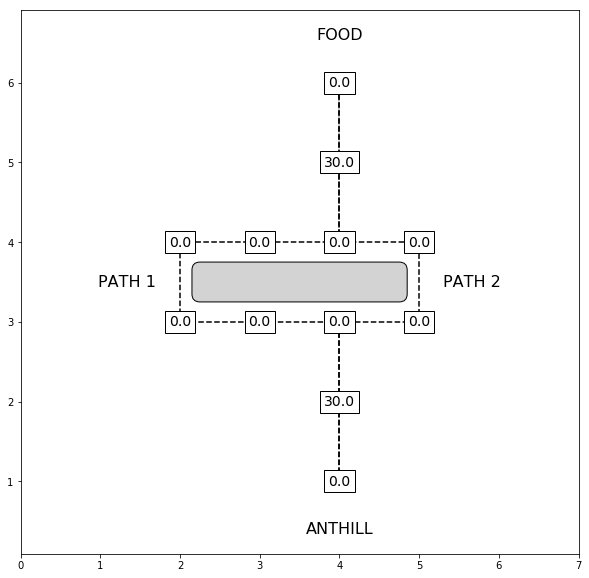

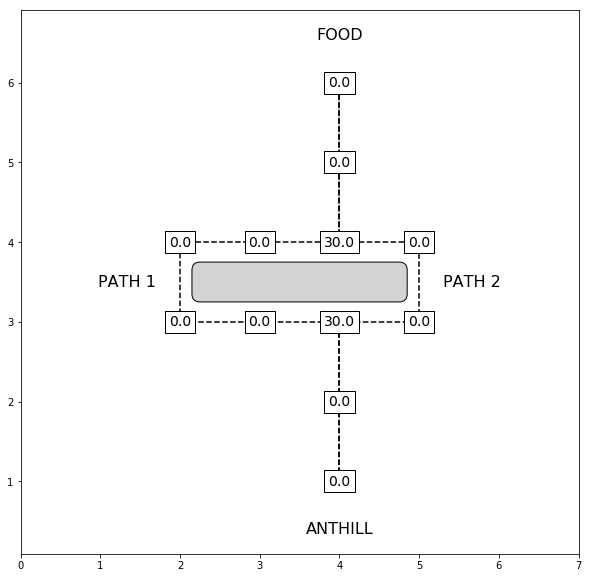

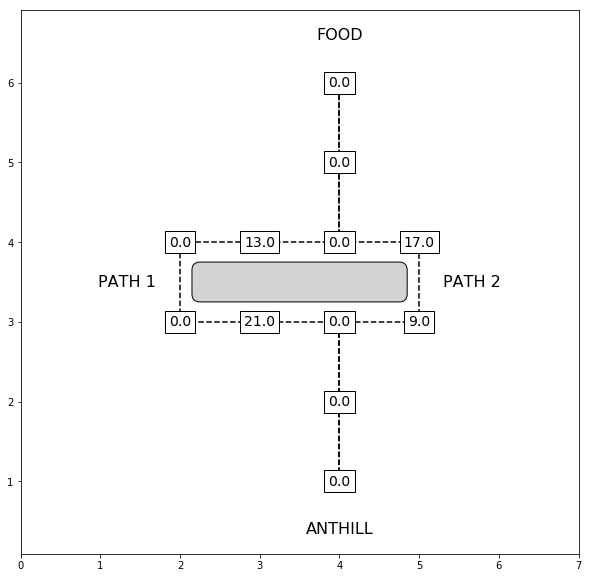

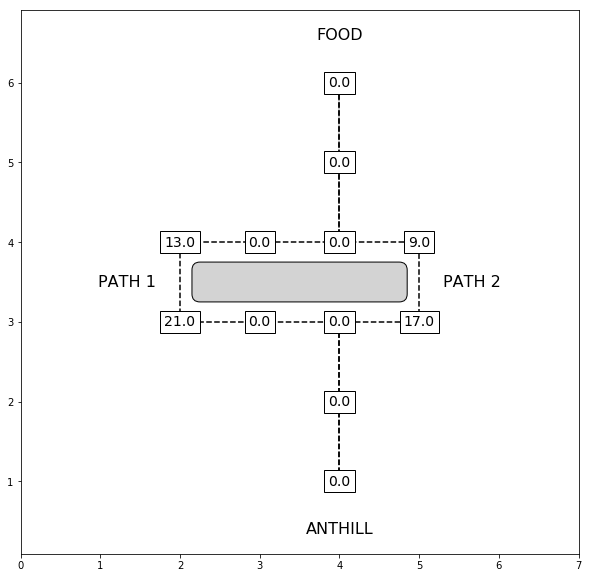

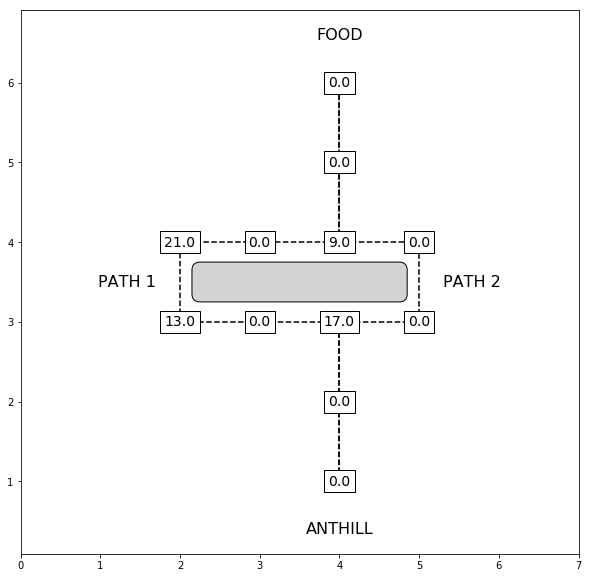

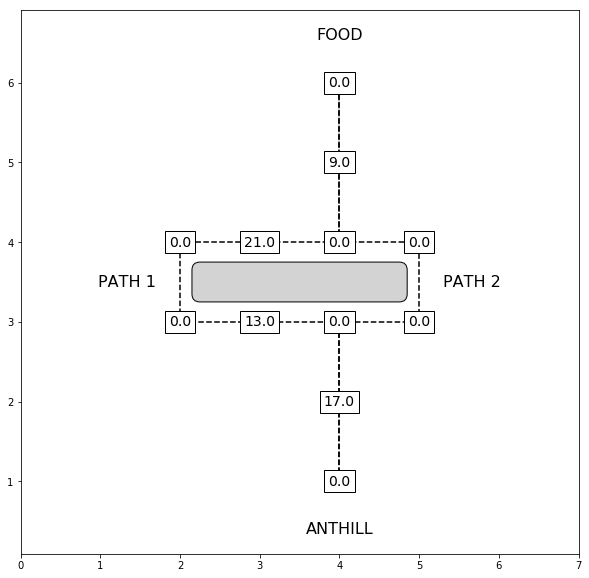

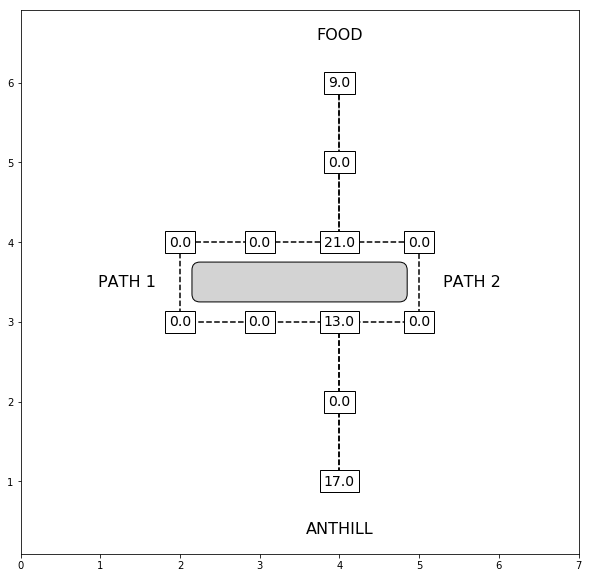

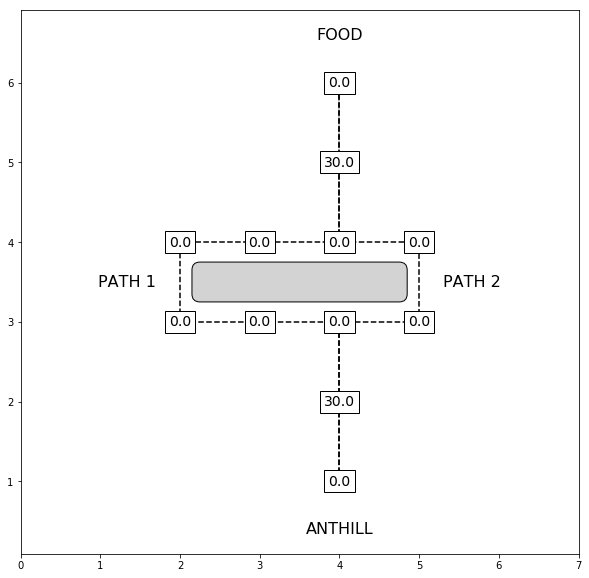

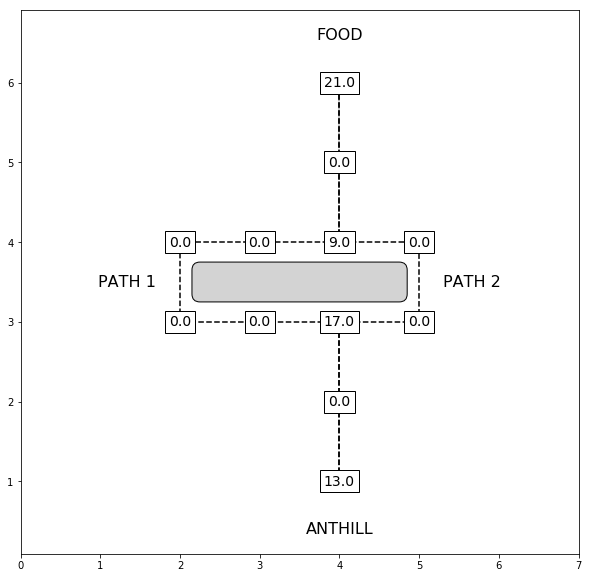

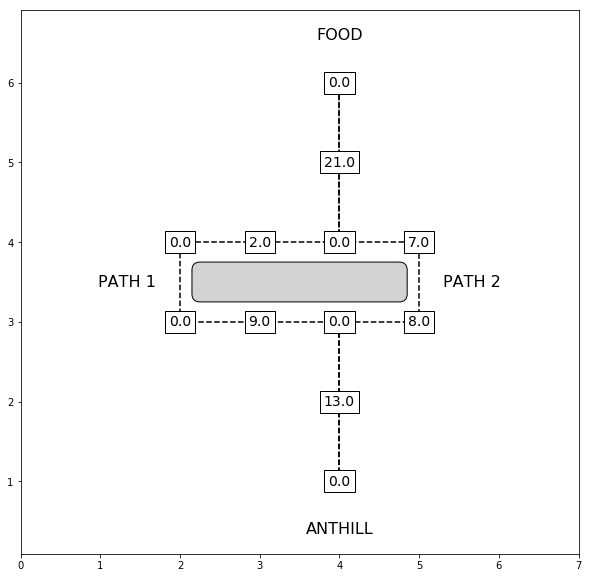

[[0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 26.0],
 [34.0, 26.0],
 [34.0, 26.0],
 [34.0, 26.0],
 [34.0, 26.0],
 [34.0, 26.0],
 [34.0, 26.0]]

In [15]:
run_for_time(10,collect_ants(),plot=True)

Since the procedure is working, run it many more times.

In [16]:
longtime = 100_000
pherotracker=run_for_time(longtime,collect_ants(),plot=False)

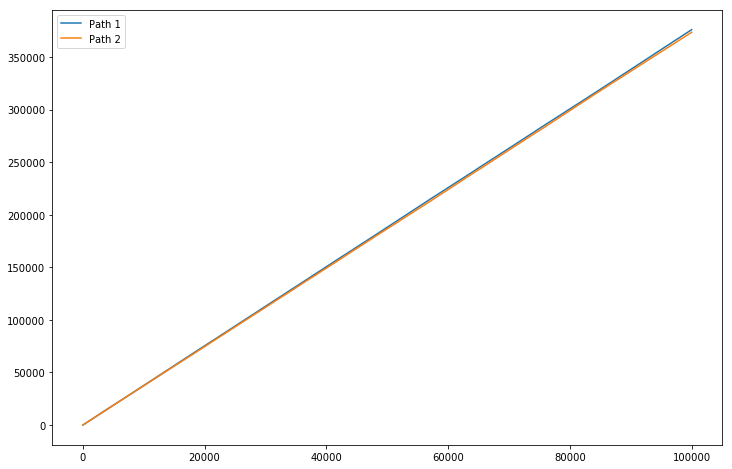

In [17]:
pt=np.array(pherotracker)
pheromonefig = plt.figure(figsize=(12,8))
plt.plot(range(longtime),pt[:,0])
plt.plot(range(longtime),pt[:,1])
plt.legend(['Path 1','Path 2'])
plt.show()

For long times, we see that the dominating one doesn't overwhelmingly win... presumably because even though the probability of success is increasing, adding at most 30 ants to the total each time doesn't have hugely meaningful affects.
This might be different if we used more ants, if we made one path length substantially longer, or introduced an evaporation parameter for the pheromone. We can also try even longer times to see results.

In [18]:
def many_run_pherotracker(numsamples,time):
    final_pheromone_vals = []
    for i in range(numsamples):
        pherotracker=run_for_time(time,collect_ants(),plot=False)
        final_pheromone_vals.append([pherotracker[-1][0],pherotracker[-1][1]])
        print(final_pheromone_vals[-1])
    return np.array(final_pheromone_vals)

In [19]:
fpv = many_run_pherotracker(50,10_000)

[38515.0, 36197.0]
[34065.0, 41918.0]
[32160.0, 44369.0]
[35327.0, 40293.0]
[28129.0, 49546.0]
[39562.0, 34850.0]
[27391.0, 50499.0]
[29126.0, 48263.0]
[37118.0, 37987.0]
[44181.0, 28909.0]
[46210.0, 26304.0]
[34492.0, 41369.0]
[35978.0, 39454.0]
[32853.0, 43476.0]
[31696.0, 44966.0]
[42332.0, 31289.0]
[40800.0, 33256.0]
[46975.0, 25319.0]
[28405.0, 49193.0]
[39381.0, 35081.0]
[26880.0, 51158.0]
[28161.0, 49507.0]
[28541.0, 49019.0]
[33214.0, 43013.0]
[36482.0, 38804.0]
[40863.0, 33173.0]
[47596.0, 24521.0]
[32279.0, 44210.0]
[37652.0, 37309.0]
[39304.0, 35179.0]
[34330.0, 41578.0]
[33435.0, 42730.0]
[38787.0, 35849.0]
[42911.0, 30541.0]
[27209.0, 50729.0]
[17583.0, 63105.0]
[36317.0, 39018.0]
[42486.0, 31093.0]
[37356.0, 37688.0]
[28508.0, 49061.0]
[33597.0, 42515.0]
[45428.0, 27308.0]
[35103.0, 40580.0]
[25539.0, 52879.0]
[39531.0, 34887.0]
[47656.0, 24442.0]
[20255.0, 59672.0]
[40245.0, 33971.0]
[28932.0, 48522.0]
[35913.0, 39543.0]


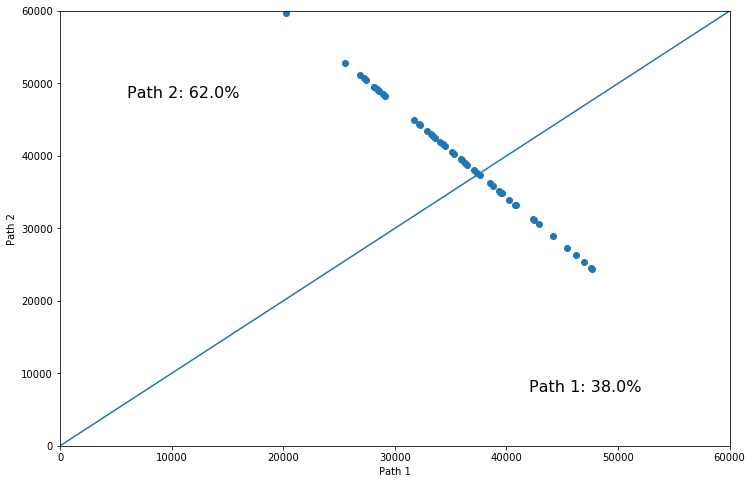

In [22]:
samplesfig = plt.figure(figsize=(12,8))
plt.scatter(fpv[:,0],fpv[:,1])
uplim = 60_000
plt.xlim(0,uplim)
plt.xlabel('Path 1')
plt.ylim(0,uplim)
plt.ylabel('Path 2')
plt.plot([0,uplim],[0,uplim])

p1_more = ((fpv[:,0]-fpv[:,1]) > 0).sum()
p1_less = ((fpv[:,0]-fpv[:,1]) < 0).sum()
p1_perc = p1_more/(p1_more+p1_less)
p2_perc = p1_less/(p1_more+p1_less)
plt.text(7*uplim/10,uplim/8,'Path 1: {}%'.format(100*p1_perc),fontsize=16)
plt.text(uplim/10,4*uplim/5,'Path 2: {}%'.format(100*p2_perc),fontsize=16)
plt.show()